In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import pandas as pd

from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    matthews_corrcoef,
)
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.svm import SVC

from ucimlrepo import fetch_ucirepo

### Data & Visualisation

Binary classification

432 instances

6 features -> 15 features

In [2]:
# fetch dataset
monk = fetch_ucirepo(id=70)

# data (as pandas dataframes)
X = monk.data.features

In [3]:
multi_value = ["a1", "a2", "a4", "a5"]
binary_value = ["a3", "a6"]

def convert_finite_integer_to_categorical(
    feature_encoding: npt.NDArray[np.int64],
) -> tuple[npt.NDArray[np.int64], npt.NDArray[np.int64]]:
    """
    Convert a finite integer column to a set of categorical columns.
    Args:
        feature_encoding: A 1D numpy array of integers.
    Returns:
        A tuple of two numpy arrays:
        - The first array is the unique values of the input array.
        - The second array is the one-hot encoding of the input array.
    """
    unique_values = np.sort(np.unique(feature_encoding))
    one_hot = np.zeros((len(feature_encoding), len(unique_values)), dtype=int)
    for i, f in enumerate(feature_encoding):
        one_hot[i, np.where(unique_values == f)[0]] = 1

    return unique_values, one_hot

In [4]:
feature_names = []
X_np = None

for col in X.columns:
    if col in multi_value:
        # if there is nan in this column, replace it with -1
        col_np = X[col].to_numpy(dtype=np.int64)
        unique_values, col_one_hot = convert_finite_integer_to_categorical(col_np)
        for val in unique_values:
            feature_names.append(f"{col}_{val}")
        if X_np is None:
            X_np = col_one_hot
        else:
            X_np = np.column_stack((X_np, col_one_hot))
    elif col in binary_value:
        col_np = X[col].copy().to_numpy(dtype=np.int64)
        col_np -= 1 # make it 0-based
        feature_names.append(f"{col}_2")
        if X_np is None:
            X_np = col_np
        else:
            X_np = np.column_stack((X_np, col_np))

y_np = monk.data.targets.to_numpy().flatten()

print(f"X shape: {X_np.shape}")
print(f"y shape: {y_np.shape}")


X shape: (432, 15)
y shape: (432,)


In [5]:
train_X, hold_out_test_X, train_y, hold_out_test_y = train_test_split(
    X_np, y_np, test_size=0.3, random_state=73, stratify=y_np
)

In [6]:
train_y.mean(), hold_out_test_y.mean()

(0.5, 0.5)

### Common code

In [7]:
# Config
NUM_FOLD = 5
RANDOM_STATE = 73

In [8]:
def get_fold_print_string(fold_result: list[float]):
    mean = np.mean(fold_result)
    ste = np.std(fold_result) / np.sqrt(NUM_FOLD)
    return f"{mean:.3f} ± {ste:.3f}"

In [9]:
def binary_classification(
    model,
    model_name: str,
    n_splits: int = NUM_FOLD,
    random_state: int = RANDOM_STATE,
):
    print(f"Model {model_name} with {n_splits}-fold cross-validation\n")
    skf = StratifiedKFold(
        n_splits=n_splits, shuffle=True, random_state=random_state
    )

    fold_accuracy = []
    fold_precision = []
    fold_recall = []
    fold_f1 = []
    fold_mcc = []

    hold_out_accuracy = []
    hold_out_precision = []
    hold_out_recall = []
    hold_out_f1 = []
    hold_out_mcc = []

    fig, ax = plt.subplots(1, 5, figsize=(15, 4))
    for i, (train_index, test_index) in enumerate(skf.split(train_X, train_y)):
        model.fit(train_X[train_index], train_y[train_index])

        y_pred = model.predict(train_X[test_index])

        acc = accuracy_score(train_y[test_index], y_pred)
        prec = precision_score(train_y[test_index], y_pred, zero_division=0)
        rec = recall_score(train_y[test_index], y_pred)
        f1 = f1_score(train_y[test_index], y_pred)
        mcc = matthews_corrcoef(train_y[test_index], y_pred)
        fold_accuracy.append(acc)
        fold_precision.append(prec)
        fold_recall.append(rec)
        fold_f1.append(f1)
        fold_mcc.append(mcc)
        print(
            f"Fold {i}: Accuracy={acc:.4f}, Precision={prec:.4f}, "
            f"Recall={rec:.4f}, F1={f1:.4f}, MCC={mcc:.4f}"
        )

        # Test on hold-out test set
        y_hold_out_pred = model.predict(hold_out_test_X)

        acc = accuracy_score(hold_out_test_y, y_hold_out_pred)
        prec = precision_score(
            hold_out_test_y, y_hold_out_pred, zero_division=0
        )
        rec = recall_score(hold_out_test_y, y_hold_out_pred)
        f1 = f1_score(hold_out_test_y, y_hold_out_pred)
        mcc = matthews_corrcoef(hold_out_test_y, y_hold_out_pred)
        hold_out_accuracy.append(acc)
        hold_out_precision.append(prec)
        hold_out_recall.append(rec)
        hold_out_f1.append(f1)
        hold_out_mcc.append(mcc)
        print(
            f"Hold-out Test: Accuracy={acc:.4f}, Precision={prec:.4f}, "
            f"Recall={rec:.4f}, F1={f1:.4f}, MCC={mcc:.4f}"
        )

        # Plot confusion matrix
        cm = confusion_matrix(train_y[test_index], y_pred)
        disp = ConfusionMatrixDisplay(
            confusion_matrix=cm, display_labels=model.classes_
        )
        disp.plot(ax=ax[i], xticks_rotation=45)
        ax[i].set_title(f"Fold {i}")

    print("\nCross-Validation Results:")
    print(f"Mean Accuracy: {get_fold_print_string(fold_accuracy)}")
    print(f"Mean Precision: {get_fold_print_string(fold_precision)}")
    print(f"Mean Recall: {get_fold_print_string(fold_recall)}")
    print(f"Mean F1 Score: {get_fold_print_string(fold_f1)}")
    print(f"Mean MCC: {get_fold_print_string(fold_mcc)}")

    print("\nHold-out Test Results:")
    print(f"Mean Accuracy: {get_fold_print_string(hold_out_accuracy)}")
    print(f"Mean Precision: {get_fold_print_string(hold_out_precision)}")
    print(f"Mean Recall: {get_fold_print_string(hold_out_recall)}")
    print(f"Mean F1 Score: {get_fold_print_string(hold_out_f1)}")
    print(f"Mean MCC: {get_fold_print_string(hold_out_mcc)}")

    plt.tight_layout()

## Logistic regression

Model Logistic Regression with 5-fold cross-validation

Fold 0: Accuracy=0.7377, Precision=0.9412, Recall=0.5161, F1=0.6667, MCC=0.5383
Hold-out Test: Accuracy=0.7769, Precision=0.9737, Recall=0.5692, F1=0.7184, MCC=0.6089
Fold 1: Accuracy=0.7049, Precision=1.0000, Recall=0.4000, F1=0.5714, MCC=0.5031
Hold-out Test: Accuracy=0.7769, Precision=1.0000, Recall=0.5538, F1=0.7129, MCC=0.6189
Fold 2: Accuracy=0.7167, Precision=0.8824, Recall=0.5000, F1=0.6383, MCC=0.4808
Hold-out Test: Accuracy=0.7769, Precision=1.0000, Recall=0.5538, F1=0.7129, MCC=0.6189
Fold 3: Accuracy=0.7667, Precision=1.0000, Recall=0.5333, F1=0.6957, MCC=0.6030
Hold-out Test: Accuracy=0.7769, Precision=1.0000, Recall=0.5538, F1=0.7129, MCC=0.6189
Fold 4: Accuracy=0.7167, Precision=0.9333, Recall=0.4667, F1=0.6222, MCC=0.5004
Hold-out Test: Accuracy=0.7385, Precision=0.8780, Recall=0.5538, F1=0.6792, MCC=0.5132

Cross-Validation Results:
Mean Accuracy: 0.729 ± 0.010
Mean Precision: 0.951 ± 0.020
Mean Recall: 0.483 ± 0.

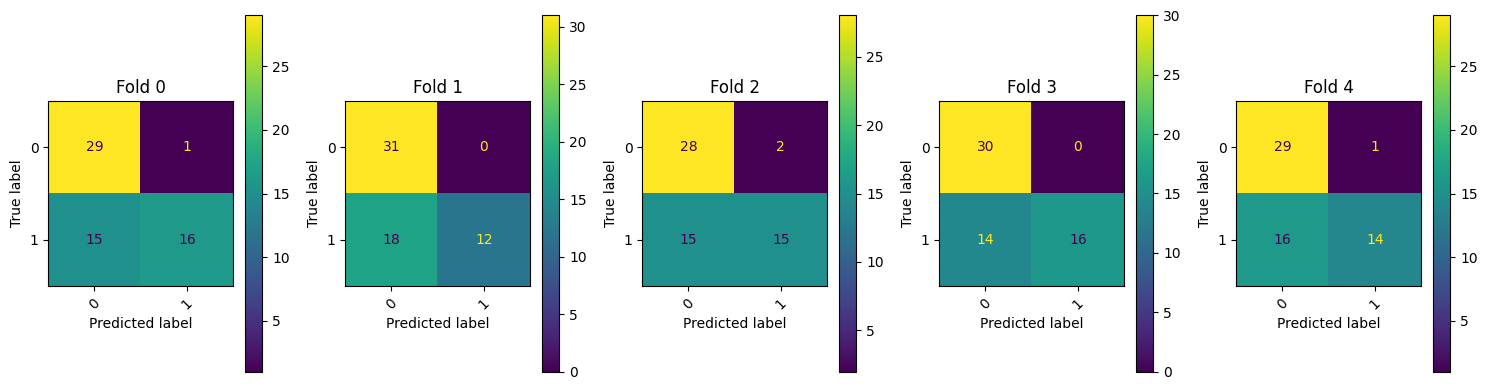

In [10]:
model = LogisticRegression(solver="liblinear")
binary_classification(model, "Logistic Regression")

## Random forest

Model Random Forest with 5-fold cross-validation

Fold 0: Accuracy=0.9508, Precision=1.0000, Recall=0.9032, F1=0.9492, MCC=0.9062
Hold-out Test: Accuracy=0.9692, Precision=1.0000, Recall=0.9385, F1=0.9683, MCC=0.9402
Fold 1: Accuracy=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000, MCC=1.0000
Hold-out Test: Accuracy=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000, MCC=1.0000
Fold 2: Accuracy=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000, MCC=1.0000
Hold-out Test: Accuracy=0.9923, Precision=1.0000, Recall=0.9846, F1=0.9922, MCC=0.9847
Fold 3: Accuracy=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000, MCC=1.0000
Hold-out Test: Accuracy=0.9769, Precision=1.0000, Recall=0.9538, F1=0.9764, MCC=0.9549
Fold 4: Accuracy=0.9833, Precision=1.0000, Recall=0.9667, F1=0.9831, MCC=0.9672
Hold-out Test: Accuracy=0.9846, Precision=1.0000, Recall=0.9692, F1=0.9844, MCC=0.9697

Cross-Validation Results:
Mean Accuracy: 0.987 ± 0.009
Mean Precision: 1.000 ± 0.000
Mean Recall: 0.974 ± 0.017
Me

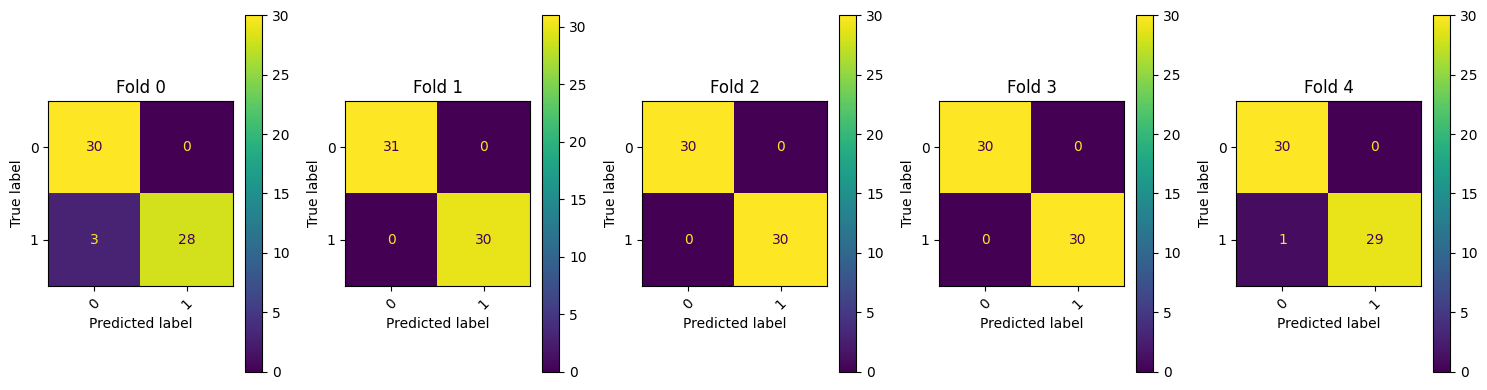

In [11]:
model = RandomForestClassifier(n_estimators=100, random_state=75)
binary_classification(model, "Random Forest")

## SVM

Model SVM with 5-fold cross-validation

Fold 0: Accuracy=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000, MCC=1.0000
Hold-out Test: Accuracy=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000, MCC=1.0000
Fold 1: Accuracy=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000, MCC=1.0000
Hold-out Test: Accuracy=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000, MCC=1.0000
Fold 2: Accuracy=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000, MCC=1.0000
Hold-out Test: Accuracy=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000, MCC=1.0000
Fold 3: Accuracy=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000, MCC=1.0000
Hold-out Test: Accuracy=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000, MCC=1.0000
Fold 4: Accuracy=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000, MCC=1.0000
Hold-out Test: Accuracy=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000, MCC=1.0000

Cross-Validation Results:
Mean Accuracy: 1.000 ± 0.000
Mean Precision: 1.000 ± 0.000
Mean Recall: 1.000 ± 0.000
Mean F1 Scor

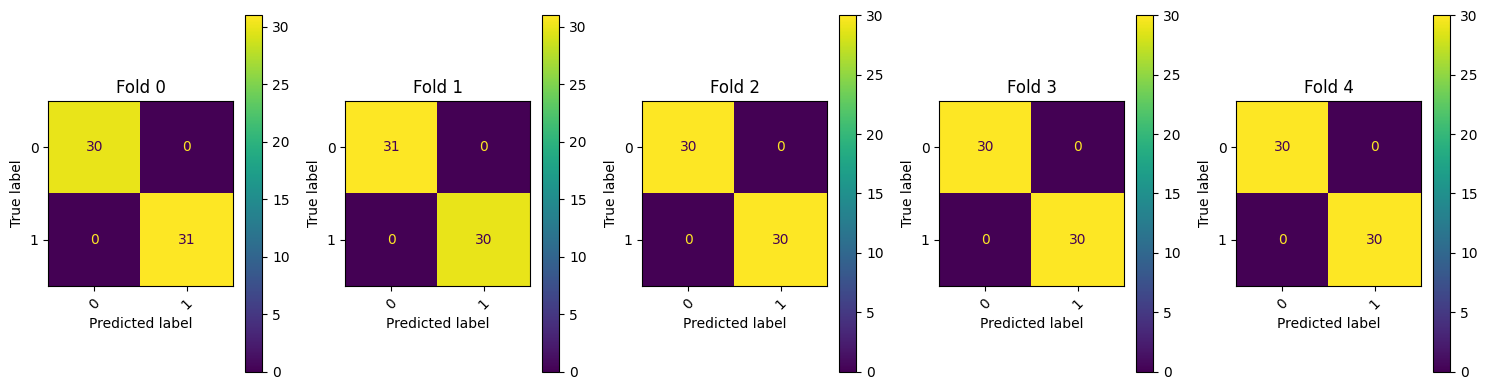

In [12]:
model = SVC(kernel="rbf", random_state=76, class_weight="balanced")
binary_classification(model, "SVM")

## Decision tree

In [13]:
# Function to calculate the average depth of the decision tree
def average_tree_depth(tree):
    def _recursive_depth(node, current_depth, depths):
        if (
            tree.children_left[node] == tree.children_right[node]
        ):  # It's a leaf node
            depths.append(current_depth)
            return
        _recursive_depth(tree.children_left[node], current_depth + 1, depths)
        _recursive_depth(tree.children_right[node], current_depth + 1, depths)

    depths = []
    _recursive_depth(0, 0, depths)  # Start from the root node (index 0)
    return sum(depths) / len(depths)


# Function to count the number of branches (internal nodes)
def count_branches(tree):
    n_nodes = tree.node_count  # Total number of nodes in the tree
    n_leaves = tree.n_leaves  # Total number of leaf nodes
    n_branches = n_nodes - n_leaves  # Number of internal nodes (branches)
    return n_branches

Decision tree with 5-fold cross-validation

Fold 0: Accuracy=0.8689, Precision=0.9259, Recall=0.8065, F1=0.8621, MCC=0.7446
Hold-out Test: Accuracy=0.8000, Precision=0.8000, Recall=0.8000, F1=0.8000, MCC=0.6000
Fold 1: Accuracy=0.9672, Precision=0.9375, Recall=1.0000, F1=0.9677, MCC=0.9365
Hold-out Test: Accuracy=0.9077, Precision=0.8630, Recall=0.9692, F1=0.9130, MCC=0.8216
Fold 2: Accuracy=0.8833, Precision=0.8485, Recall=0.9333, F1=0.8889, MCC=0.7705
Hold-out Test: Accuracy=0.8077, Precision=0.7941, Recall=0.8308, F1=0.8120, MCC=0.6160
Fold 3: Accuracy=0.8667, Precision=0.8235, Recall=0.9333, F1=0.8750, MCC=0.7399
Hold-out Test: Accuracy=0.9000, Precision=0.8611, Recall=0.9538, F1=0.9051, MCC=0.8047
Fold 4: Accuracy=0.9667, Precision=1.0000, Recall=0.9333, F1=0.9655, MCC=0.9354
Hold-out Test: Accuracy=0.9538, Precision=0.9683, Recall=0.9385, F1=0.9531, MCC=0.9081

Cross-Validation Results:
Mean Accuracy: 0.911 ± 0.021
Mean Precision: 0.907 ± 0.029
Mean Recall: 0.921 ± 0.028
Mean F1 

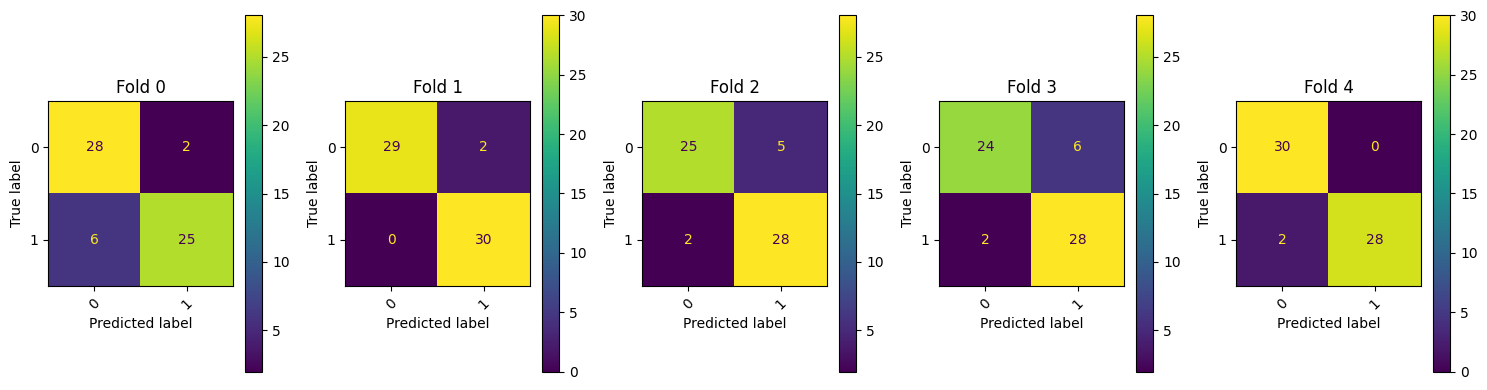

In [14]:
model = DecisionTreeClassifier(random_state=77, class_weight="balanced")
print(f"Decision tree with {NUM_FOLD}-fold cross-validation\n")
skf = StratifiedKFold(n_splits=NUM_FOLD, shuffle=True, random_state=77)

fold_accuracy = []
fold_precision = []
fold_recall = []
fold_f1 = []
fold_mcc = []
tree_stats: list[dict[str, float]] = []
hold_out_accuracy = []
hold_out_precision = []
hold_out_recall = []
hold_out_f1 = []
hold_out_mcc = []

fig, ax = plt.subplots(1, NUM_FOLD, figsize=(15, 4))
for i, (train_index, test_index) in enumerate(skf.split(train_X, train_y)):
    model.fit(train_X[train_index], train_y[train_index])

    y_pred = model.predict(train_X[test_index])

    acc = accuracy_score(train_y[test_index], y_pred)
    prec = precision_score(train_y[test_index], y_pred, zero_division=0)
    rec = recall_score(train_y[test_index], y_pred)
    f1 = f1_score(train_y[test_index], y_pred)
    mcc = matthews_corrcoef(train_y[test_index], y_pred)
    max_depth = model.get_depth()
    avg_depth = average_tree_depth(model.tree_)
    n_branches = count_branches(model.tree_)

    fold_accuracy.append(acc)
    fold_precision.append(prec)
    fold_recall.append(rec)
    fold_f1.append(f1)
    fold_mcc.append(mcc)
    tree_stats.append(
        {
            "max_depth": max_depth,
            "avg_depth": avg_depth,
            "n_branches": n_branches,
        }
    )

    print(
        f"Fold {i}: Accuracy={acc:.4f}, Precision={prec:.4f}, "
        f"Recall={rec:.4f}, F1={f1:.4f}, MCC={mcc:.4f}"
    )

    # Test on hold-out test set
    y_hold_out_pred = model.predict(hold_out_test_X)

    acc = accuracy_score(hold_out_test_y, y_hold_out_pred)
    prec = precision_score(hold_out_test_y, y_hold_out_pred, zero_division=0)
    rec = recall_score(hold_out_test_y, y_hold_out_pred)
    f1 = f1_score(hold_out_test_y, y_hold_out_pred)
    mcc = matthews_corrcoef(hold_out_test_y, y_hold_out_pred)
    hold_out_accuracy.append(acc)
    hold_out_precision.append(prec)
    hold_out_recall.append(rec)
    hold_out_f1.append(f1)
    hold_out_mcc.append(mcc)
    print(
        f"Hold-out Test: Accuracy={acc:.4f}, Precision={prec:.4f}, "
        f"Recall={rec:.4f}, F1={f1:.4f}, MCC={mcc:.4f}"
    )

    # Plot confusion matrix
    cm = confusion_matrix(train_y[test_index], y_pred)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=model.classes_
    )
    disp.plot(ax=ax[i], xticks_rotation=45)
    ax[i].set_title(f"Fold {i}")

print("\nCross-Validation Results:")
print(f"Mean Accuracy: {get_fold_print_string(fold_accuracy)}")
print(f"Mean Precision: {get_fold_print_string(fold_precision)}")
print(f"Mean Recall: {get_fold_print_string(fold_recall)}")
print(f"Mean F1 Score: {get_fold_print_string(fold_f1)}")
print(f"Mean MCC: {get_fold_print_string(fold_mcc)}")

print("\nHold-out Test Results:")
print(f"Mean Accuracy: {get_fold_print_string(hold_out_accuracy)}")
print(f"Mean Precision: {get_fold_print_string(hold_out_precision)}")
print(f"Mean Recall: {get_fold_print_string(hold_out_recall)}")
print(f"Mean F1 Score: {get_fold_print_string(hold_out_f1)}")
print(f"Mean MCC: {get_fold_print_string(hold_out_mcc)}")

print("\nTree Stats:")
print(
    f"Avg Max Depth: {get_fold_print_string([x['max_depth'] for x in tree_stats])}"
)
print(
    f"Avg Avg Depth: {get_fold_print_string([x['avg_depth'] for x in tree_stats])}"
)
print(
    f"Avg Branches: {get_fold_print_string([x['n_branches'] for x in tree_stats])}"
)

plt.tight_layout()

[Text(0.7900943396226415, 0.9545454545454546, 'a5_1 <= 0.5\ngini = 0.5\nsamples = 242\nvalue = [121, 121]'),
 Text(0.7712264150943396, 0.8636363636363636, 'a1_2 <= 0.5\ngini = 0.446\nsamples = 182\nvalue = [121.0, 61.0]'),
 Text(0.7806603773584906, 0.9090909090909092, 'True  '),
 Text(0.7334905660377359, 0.7727272727272727, 'a2_2 <= 0.5\ngini = 0.461\nsamples = 125\nvalue = [80, 45]'),
 Text(0.714622641509434, 0.6818181818181818, 'a4_2 <= 0.5\ngini = 0.499\nsamples = 86\nvalue = [41, 45]'),
 Text(0.5047169811320755, 0.5909090909090909, 'a5_3 <= 0.5\ngini = 0.499\nsamples = 59\nvalue = [31.0, 28.0]'),
 Text(0.25471698113207547, 0.5, 'a6_2 <= 0.5\ngini = 0.486\nsamples = 36\nvalue = [21, 15]'),
 Text(0.10377358490566038, 0.4090909090909091, 'a5_2 <= 0.5\ngini = 0.43\nsamples = 16\nvalue = [11, 5]'),
 Text(0.05660377358490566, 0.3181818181818182, 'a2_3 <= 0.5\ngini = 0.245\nsamples = 7\nvalue = [6, 1]'),
 Text(0.03773584905660377, 0.22727272727272727, 'a1_1 <= 0.5\ngini = 0.444\nsamples =

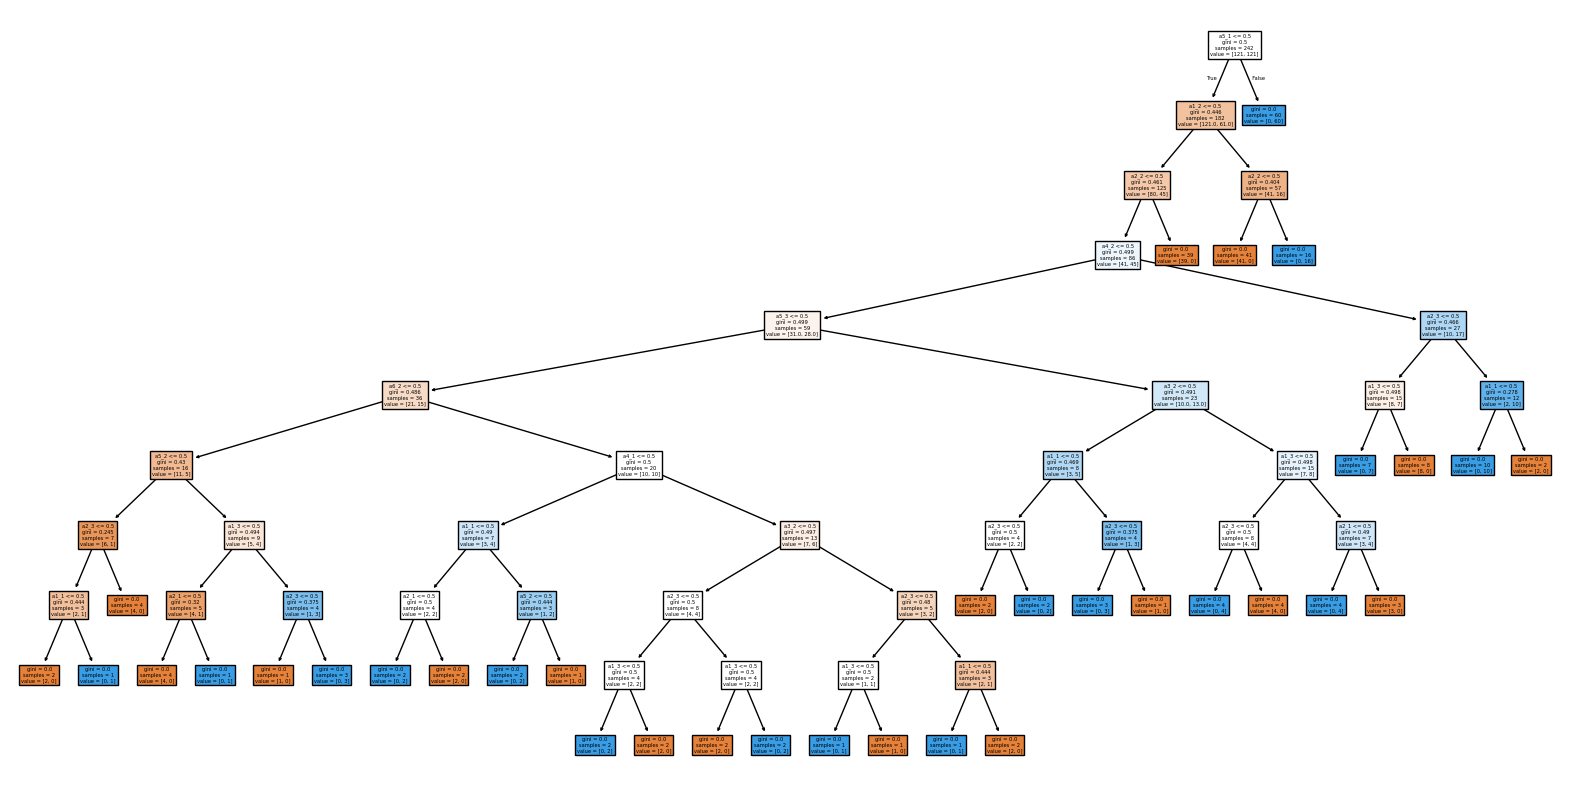

In [15]:
# display the decision tree
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(model, filled=True, feature_names=feature_names)